# Figure: PCA

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pickle
import matplotlib

import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120     # only affects the notebook

sns_styleset()

In [2]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = np.array(X)
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [3]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    stop = False
        if stop:
            break

In [4]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))

X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (1213, 1000) 
Shape of Y: (1213, 16)


In [5]:
from sklearn.decomposition import PCA

Zx = PCA(n_components=2, svd_solver='full').fit_transform(X)  
Zy = PCA(n_components=2, svd_solver='full').fit_transform(Y)  
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)

<IPython.core.display.Javascript object>


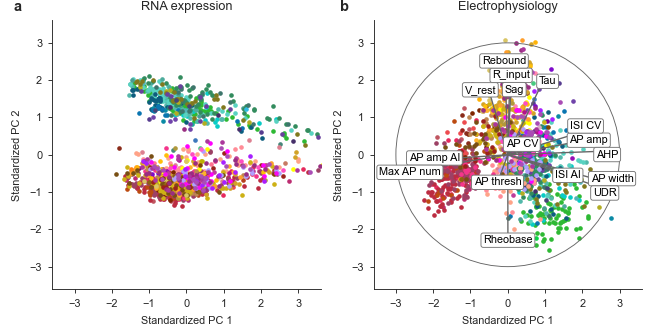

In [16]:
fig = plt.figure(figsize=(5, 2.5))

plt.subplot(121, aspect='equal')
for t in np.unique(data['ttype']):
    ind = data['ttype']==t
    plt.scatter(Zx[ind,0], Zx[ind,1], s=3, color=data['colors'][t])
    
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
plt.title('RNA expression')

plt.xlabel('Standardized PC 1')
plt.ylabel('Standardized PC 2')


plt.subplot(122, aspect='equal')
for t in np.unique(data['ttype']):
    ind = data['ttype']==t
    plt.scatter(Zy[ind,0], Zy[ind,1], s=3, color=data['colors'][t])
    
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
plt.title('Electrophysiology')

scaleFactor = 3
labels = []
L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['ephysNames'][i], 
             ha='center', va='center', color='k', fontsize=6,
             bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

fig.text(.02, 1, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.52, 1, 'b', fontsize=8, fontweight='bold', va='top')

plt.xlabel('Standardized PC 1')
plt.ylabel('Standardized PC 2')

sns.despine()#left=True, bottom=True)
plt.tight_layout()

plt.savefig('figures/pca.png', dpi=200)
plt.savefig('figures/pca.pdf')

Correlation between PC1 and sequencing depth: 0.90


<IPython.core.display.Javascript object>


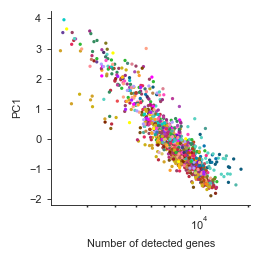

In [7]:
numDetected = np.array(np.sum(data['counts']>0, axis=1)).squeeze()

rho = np.corrcoef(np.log10(numDetected), Zx[:,0])[0,1]
print('Correlation between PC1 and sequencing depth: {:.2f}'.format(np.abs(rho)))

plt.figure(figsize=(2,2))
plt.scatter(numDetected, Zx[:,0], s=1, color=[data['colors'][t] for t in data['ttype']])
plt.xscale('log')
plt.ylabel('PC1')
plt.xlabel('Number of detected genes')
sns.despine()
plt.tight_layout()